# How to color your Map: The Good, the Bad and the Ugly
**An example using TUWien Surface Soil Moisture developed for GHG-Kit**

![](https://upload.wikimedia.org/wikipedia/en/4/45/Good_the_bad_and_the_ugly_poster.jpg)

*Image from [wikipedia](https://upload.wikimedia.org/wikipedia/en/4/45/Good_the_bad_and_the_ugly_poster.jpg)*.

In [1]:
import xarray as xr

from pathlib import Path
from tuw_education_notebooks.view_seasonal_ssm import view_seasonal_ssm, load_cmap

RESOURCES = Path("data")

In [2]:
SSM_dc = xr.open_zarr(RESOURCES / "SSM-CD-SIG40-R-DVEG_2018.zarr/")
SSM_dc

<xarray.Dataset> Size: 8GB
Dimensions:      (time: 723, y: 1200, x: 1200)
Coordinates:
  * time         (time) datetime64[ns] 6kB 2018-01-01T05:08:47 ... 2018-12-31...
  * x            (x) float64 10kB 4.8e+06 4.801e+06 ... 5.399e+06 5.4e+06
  * y            (y) float64 10kB 1.8e+06 1.799e+06 ... 1.201e+06 1.2e+06
Data variables:
    band_data    (time, y, x) float64 8GB dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    spatial_ref  int64 8B ...

Use a bad colormap bifurcating red blue scale. Then show brown to blue BBM scale.

In [3]:
SSM_dc_qs = SSM_dc.resample(time="QS-DEC").mean()


## The Bad

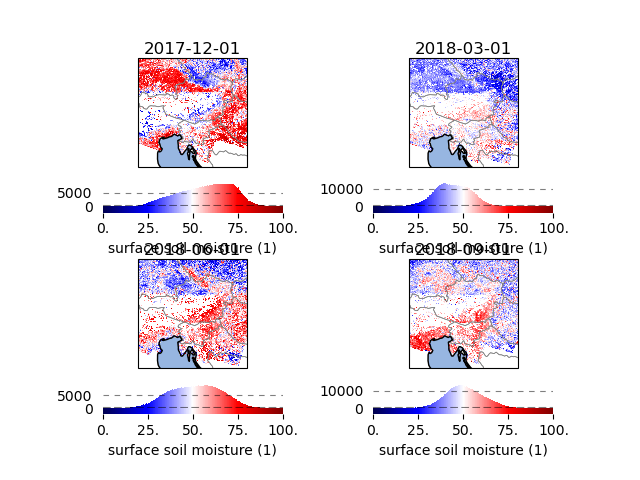

In [4]:
view_seasonal_ssm(SSM_dc_qs, "seismic")

## The Ugly

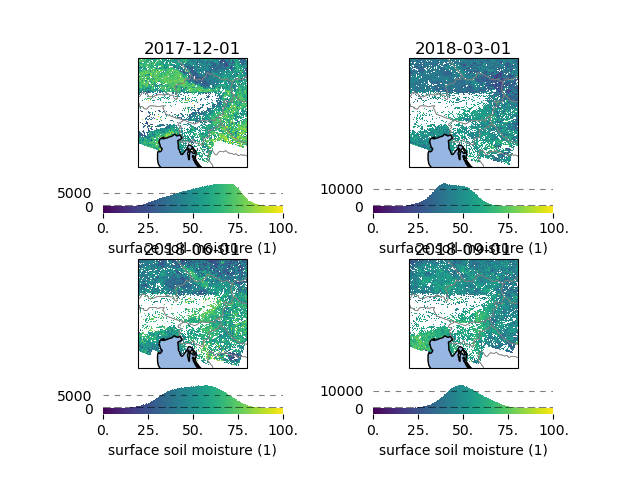

In [5]:
view_seasonal_ssm(SSM_dc_qs, "viridis")

## The Good

This last step is more subjective and relates to the psychology of colors: the multiple meanings and feelings that people associated with a color. Here we use a linear color gradient developed by TU Wien from brown for dry soils to blue for wet soils.

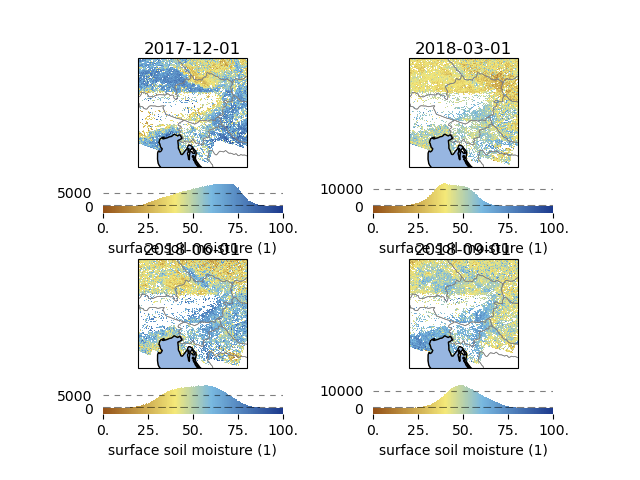

In [6]:
SSM_CMAP = load_cmap(RESOURCES / "colour-tables/ssm-continuous.ct")
view_seasonal_ssm(SSM_dc_qs, SSM_CMAP)